In [1]:
# Import required libraries

import pandas as pd
import numpy as np 

In [2]:
import gzip
import os   
from os.path import basename
import glob 
import time
import cv2  
import random
from PIL import Image  
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.misc import imresize
from skimage.transform import resize 

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.optimizers import Adam 
from keras.optimizers import SGD  
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras import backend as K

K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [4]:
os.system
os.spawnl

<function os.spawnl>

In [5]:
#read data

In [6]:
INPUT_PATH = 'C:\\Temp\\BigData\\Image masking\\'
dims = [128, 128] 
img_rows = dims[0]
img_cols = dims[1]
train = sorted(glob.glob(INPUT_PATH + 'train/*.jpg'))
masks = sorted(glob.glob(INPUT_PATH + 'train_masks/*.gif'))
test  = sorted(glob.glob(INPUT_PATH + 'test/*.jpg'))
print('Number of training images: ', len(train), 
      ' Number of corresponding masks: ', len(masks), 
      ' Number of test images: ', len(test))

meta = pd.read_csv(INPUT_PATH + 'metadata.csv')
mask_df = pd.read_csv(INPUT_PATH + 'train_masks.csv')
ids_train = mask_df['img'].map(lambda s: s.split('_')[0]).unique()
print('Length of ids_train ', len(ids_train))

Number of training images:  1500  Number of corresponding masks:  5088  Number of test images:  0
Length of ids_train  318


In [7]:
mask_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


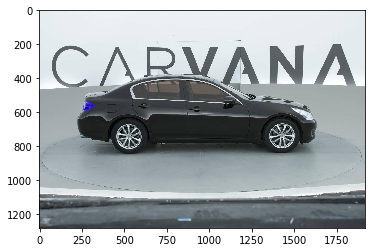

In [8]:
#display image
image = cv2.imread(INPUT_PATH + 'train/11f3dc041cfb_13.jpg')
plt.imshow(image)
plt.show()

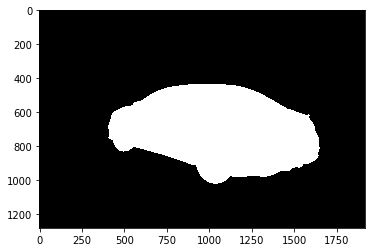

In [9]:
#Read the gif image and get the boundry
img = Image.open(INPUT_PATH + 'train_masks/1e6f48393e17_07_mask.gif').convert('RGB')
plt.imshow(img)
plt.show()

In [10]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [11]:
# U-Net model has 9 layers
def get_unet():
    # passing images rows and no. of columns
    inputs = Input((3,img_rows, img_cols))
    
    # extract features from the logical region of an input
    # most convolitional NN containsa combination of convolution pooling and layers.
    # using padding, activation function and max pooling
    # reading data in pixel format using activation function relu
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)    
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # patch size of window is 2x2 (grid format)
    # helps to reduce dimensionality of representation 
    # resulting into a feature matrix
    
    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv2)    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv9)

    #passing to sigmoid activation function
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)   #9

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(5e-4), loss='binary_crossentropy', metrics=[dice_coef])

    return model


In [12]:
# split the train set into train and validation:
train_images, validation_images = train_test_split(train, train_size=0.8, test_size=0.2)
print('Split into training set with ', len(train_images), ' images '
      'and validation set with  ', len(validation_images), ' images')

Split into training set with  1200  images and validation set with   300  images


In [13]:
# function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator to read the data from the directory
def data_gen_small(data_dir, masks, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images to generate batches from
        batch_size: self explanatory
        dims: the dimensions to rescale the images
        
        Image.resize(size, resample=0)

        Returns a resized copy of this image.
        Parameters:	

        size – The requested size in pixels, as a 2-tuple: (width, height).
        resample – An optional resampling filter.
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = cv2.imread(images[i])
                resized_img = imresize(original_img, dims+[3]) 
                array_img = resized_img / 255   
                array_img = array_img.swapaxes(0,2)
                imgs.append(array_img)
                #imgs is a numpy array with dim: (batch size X 128 X 128 X 3)
                
                # masks
                mask_filename = basename(images[i])
                no_extension = os.path.splitext(mask_filename)[0]
                correct_mask = INPUT_PATH + 'train_masks/' + no_extension + '_mask.gif' 
                original_mask = Image.open(correct_mask).convert('L')
                data = np.asarray( original_mask, dtype="int32" )
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = resized_mask / 255
                labels.append(array_mask)
            imgs = np.array(imgs)
            labels = np.array(labels)
            relabel = labels.reshape(-1, dims[0], dims[1], 1)
            yield imgs, relabel.swapaxes(1, 3)



C:\Users\MD\AppData\Local\conda\conda\envs\Python35\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\MD\AppData\Local\conda\conda\envs\Python35\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Size of batch:  2
shape of img  (2, 3, 128, 128) number dimensions:  3
shape of msk  (2, 1, 128, 128) number dimensions:  3


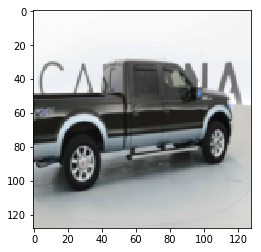

C:\Users\MD\AppData\Local\conda\conda\envs\Python35\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


resized up:  (1280, 1918, 3)
resized swapaxes:  (1918, 1280, 3)
resized swapaxes shape[-1]:  3


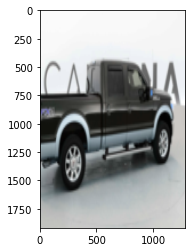

(2, 128, 128, 1)


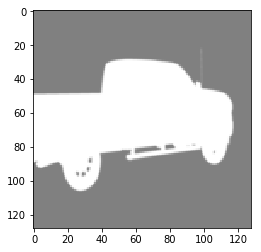

In [14]:
train_gen = data_gen_small(INPUT_PATH + 'train/', masks, train_images, 2, dims) 
img, msk = next(train_gen)
print('Size of batch: ', len(img))
print('shape of img ', img.shape, 'number dimensions: ', img[0].ndim)
print('shape of msk ', msk.shape, 'number dimensions: ', msk[0].ndim)
newshape = img[0].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

#resize up 

resized_img = imresize(img[0], [1280, 1918]+[3])
print('resized up: ', resized_img.shape)
newshape = resized_img.swapaxes(0,1)
print('resized swapaxes: ', newshape.shape)
print('resized swapaxes shape[-1]: ', newshape.shape[-1])

plt.imshow(newshape)
plt.show()

newshape = msk.swapaxes(1,3)
print(newshape.shape)
plt.imshow(grey2rgb(newshape[0]), alpha=0.5)
plt.show()

In [15]:
# create an instance of a validation generator:
validation_gen = data_gen_small(INPUT_PATH + 'train/', masks, validation_images, 4, dims) 

In [16]:
# define and compile the model
model = get_unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 128) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [17]:
# fit the model and check dice_coef on validation data at end of each epoch
model.fit_generator(train_gen, steps_per_epoch=50, epochs=1, validation_data=validation_gen, validation_steps=50)

Epoch 1/1


C:\Users\MD\AppData\Local\conda\conda\envs\Python35\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\MD\AppData\Local\conda\conda\envs\Python35\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


50/50 [==============================] - 814s 16s/step - loss: 0.4190 - dice_coef: 0.3394 - val_loss: 0.2922 - val_dice_coef: 0.5796


In [18]:
# looking at one of the predicted masks
img, msk = next(validation_gen)
predicted_mask = model.predict(img)
predicted_mask.shape

C:\Users\MD\AppData\Local\conda\conda\envs\Python35\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\MD\AppData\Local\conda\conda\envs\Python35\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(4, 1, 128, 128)

newshape shape  (4, 128, 128, 1)
grey shape  (128, 128, 3)


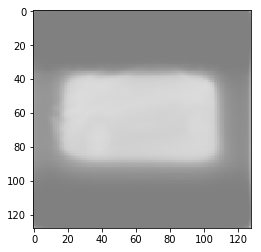

In [19]:
newshape = predicted_mask.swapaxes(1,3)
print('newshape shape ', newshape.shape)
grey = grey2rgb(newshape[3])
print('grey shape ', grey.shape)
plt.imshow(grey, alpha = 0.5)
plt.show()

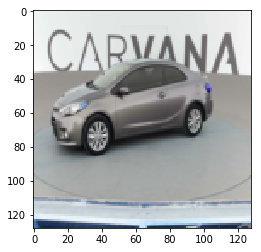

In [20]:
# the corresponding image is:
newshape = img[3].swapaxes(0,2)
plt.imshow(newshape)
plt.show()